# BIT Detection Kit Prototyping Demo Notebook
The following notebook describes the steps taken and outputs obtained using Mask R-CNN for object detection.

### Import Packages

In [1]:
import os
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


from src import dkit
%matplotlib inline

Using TensorFlow backend.


### Configurations

Run one of the code blocks below to import and load the configurations to use.

In [9]:
config = dkit.DkitConfig()
# DATA_DIR = os.path.join(ROOT_DIR, "datasets")
DATA_DIR = os.path.abspath("../../../OneDrive - BIT Consulting GmbH/Datasets")
print("Using " + DATA_DIR +" as data directory.")

Using /Users/shashwatjain/OneDrive - BIT Consulting GmbH/Datasets as data directory.


### Download & Extract Dataset
We download the dataset file and extract the dataset.

In [12]:
!wget -P $DATA_DIR https://s3-ap-southeast-1.amazonaws.com/dkitdatasets/Archive.zip
!unzip -o $DATA_DIR/Archive.zip -d $DATA_DIR

### Loading the Dataset

In [13]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = dkit.DkitDataset()
dataset.load_dkit(DATA_DIR+'/IKEA_FIXA', "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 95
Class Count: 5
  0. BG                                                
  1. Drill                                             
  2. Screw                                             
  3. Charger                                           
  4. Bit 1                                             


### Display Samples

Load and display images and masks.

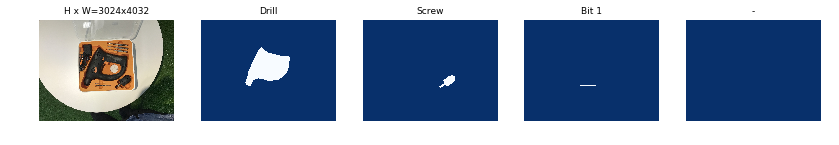

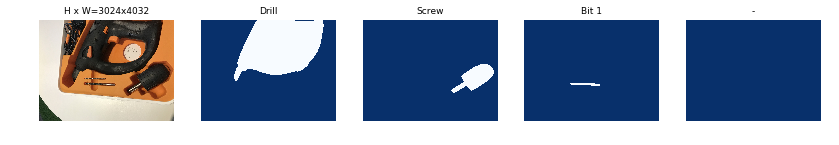

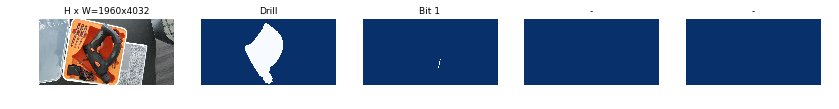

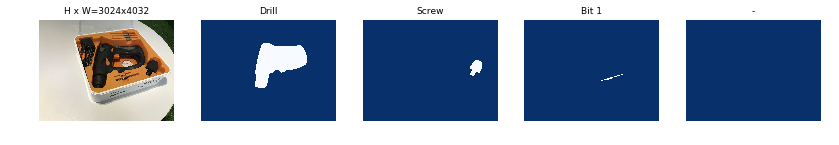

In [11]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Fire up an EC2 Instance

In [32]:
!docker-machine create --amazonec2-instance-type p2.xlarge --driver amazonec2 dkit-trainer

Running pre-create checks...
Creating machine...
(dkit-trainer) Launching instance...
(dkit-trainer) Missing instance ID, this is likely due to a failure during machine creation
Error creating machine: Error in driver during machine creation: Error launching instance: InvalidAMIID.NotFound: The image id '[ami-0b419c3a4b01d1859]' does not exist
	status code: 400, request id: cc098e90-d661-40a0-b101-beb6ab9614da


In [31]:
# !docker-machine ssh dkit-trainer git clone https://github.com/codeyogi911/Dkit.git
!docker-machine ssh dkit-trainer DEBIAN_FRONTEND=noninteractive
!docker-machine ssh dkit-trainer sudo apt-get update
!docker-machine ssh dkit-trainer sudo apt-get -y upgrade
!docker-machine ssh dkit-trainer sudo apt install -y python-pip
pip install --upgrade pipls


Hit:1 http://security.ubuntu.com/ubuntu xenial-security InRelease
Hit:2 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial InRelease
Hit:3 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates InRelease
Hit:4 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-backports InRelease
Hit:5 https://download.docker.com/linux/ubuntu xenial InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
Calculating upgrade...
The following packages have been kept back:
  linux-aws linux-headers-aws linux-image-aws open-vm-tools ubuntu-minimal
The following packages will be upgraded:
  apparmor apport apt apt-utils base-files bind9-host bsdutils
  busybox-initramfs busybox-static cloud-guest-utils cloud-init
  cloud-initramfs-copymods cloud-initramfs-dyn-netconf console-setup
  console-setup-linux distro-info-data dns-root-data dnsmasq-base dnsutils
  dpkg file friendly-recovery gcc-5-base gettext-base git git-man gnupg gpgv
  gr

Get:47 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 busybox-initramfs amd64 1:1.22.0-15ubuntu1.4 [179 kB]
Get:48 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libasprintf0v5 amd64 0.19.7-2ubuntu3.1 [6,568 B]
Get:49 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 gettext-base amd64 0.19.7-2ubuntu3.1 [48.0 kB]
Get:50 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 linux-base all 4.5ubuntu1~16.04.1 [18.1 kB]
Get:51 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 systemd-sysv amd64 229-4ubuntu21.21 [11.1 kB]
Get:52 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 iproute2 amd64 4.3.0-1ubuntu3.16.04.5 [523 kB]
Get:53 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libapparmor1 amd64 2.10.95-0ubuntu2.10 [29.7 kB]
Get:54 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libmount1 amd64 2.27.1-6

Get:112 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libisccc140 amd64 1:9.10.3.dfsg.P4-8ubuntu1.14 [16.3 kB]
Get:113 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libisccfg140 amd64 1:9.10.3.dfsg.P4-8ubuntu1.14 [40.5 kB]
Get:114 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 liblwres141 amd64 1:9.10.3.dfsg.P4-8ubuntu1.14 [34.1 kB]
Get:115 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libbind9-140 amd64 1:9.10.3.dfsg.P4-8ubuntu1.14 [23.6 kB]
Get:116 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 busybox-static amd64 1:1.22.0-15ubuntu1.4 [874 kB]
Get:117 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 hdparm amd64 9.48+ds-1ubuntu0.1 [92.6 kB]
Get:118 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 krb5-locales all 1.13.2+dfsg-5ubuntu2.1 [13.6 kB]
Get:119 http://us-east-1.ec2.archive.ubuntu.com/ubuntu xenia

Processing triggers for plymouth-theme-ubuntu-text (0.9.2-3ubuntu13.2) ...
update-initramfs: deferring update (trigger activated)
Processing triggers for man-db (2.7.5-1) ...
Processing triggers for install-info (6.1.0.dfsg.1-5) ...
Processing triggers for initramfs-tools (0.122ubuntu8.10) ...
update-initramfs: Generating /boot/initrd.img-4.4.0-1052-aws
W: mdadm: /etc/mdadm/mdadm.conf defines no arrays.
Setting up base-files (9.4ubuntu4.8) ...
Installing new version of config file /etc/issue ...
Installing new version of config file /etc/issue.net ...
Installing new version of config file /etc/lsb-release ...
Processing triggers for plymouth-theme-ubuntu-text (0.9.2-3ubuntu13.2) ...
update-initramfs: deferring update (trigger activated)
Processing triggers for initramfs-tools (0.122ubuntu8.10) ...
update-initramfs: Generating /boot/initrd.img-4.4.0-1052-aws
W: mdadm: /etc/mdadm/mdadm.conf defines no arrays.
(Reading database ... 51355 files and directories currently installed.)
Prepari

Setting up libpam-runtime (1.1.8-3.2ubuntu2.1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 51364 files and directories currently installed.)
Preparing to unpack .../passwd_1%3a4.2-3.1ubuntu5.4_amd64.deb ...
Unpacking passwd (1:4.2-3.1ubuntu5.4) over (1:4.2-3.1ubuntu5.3) ...
Processing triggers for man-db (2.7.5-1) ...
Processing triggers for ureadahead (0.100.0-19) ...
Setting up passwd (1:4.2-3.1ubuntu5.4) ...
(Reading database ... 51364 files and directories currently installed.)
Preparing to unpack .../libuuid1_2.27.1-6ubuntu3.6_amd64.deb ...
Unpacking libuuid1:amd64 (2.27.1-6ubuntu3.6) over (2.27.1-6ubuntu3.4) ...
Processing triggers for libc-bin (2.23-0ubuntu11) ...
Setting up libuuid1:amd64 (2.27.1-6ubuntu3.6) ...
Processing triggers for libc-bin (2.23-0ubuntu11) ...
(Reading database ... 51

Preparing to unpack .../libpython3.5-minimal_3.5.2-2ubuntu0~16.04.5_amd64.deb ...
Unpacking libpython3.5-minimal:amd64 (3.5.2-2ubuntu0~16.04.5) over (3.5.2-2ubuntu0~16.04.4) ...
Preparing to unpack .../libsqlite3-0_3.11.0-1ubuntu1.1_amd64.deb ...
Unpacking libsqlite3-0:amd64 (3.11.0-1ubuntu1.1) over (3.11.0-1ubuntu1) ...
Preparing to unpack .../libglib2.0-0_2.48.2-0ubuntu4.1_amd64.deb ...
Unpacking libglib2.0-0:amd64 (2.48.2-0ubuntu4.1) over (2.48.2-0ubuntu1) ...
Preparing to unpack .../libgcrypt20_1.6.5-2ubuntu0.5_amd64.deb ...
Unpacking libgcrypt20:amd64 (1.6.5-2ubuntu0.5) over (1.6.5-2ubuntu0.3) ...
Processing triggers for libc-bin (2.23-0ubuntu11) ...
Processing triggers for mime-support (3.59ubuntu1) ...
Processing triggers for man-db (2.7.5-1) ...
Setting up libgcrypt20:amd64 (1.6.5-2ubuntu0.5) ...
Processing triggers for libc-bin (2.23-0ubuntu11) ...
(Reading database ... 51371 files and directories currently installed.)
Preparing to unpack .../ntfs-3g_1%3a2015.3.14AR.1-1ubuntu0

Preparing to unpack .../sudo_1.8.16-0ubuntu1.6_amd64.deb ...
Unpacking sudo (1.8.16-0ubuntu1.6) over (1.8.16-0ubuntu1.5) ...
Preparing to unpack .../ureadahead_0.100.0-19.1_amd64.deb ...
Unpacking ureadahead (0.100.0-19.1) over (0.100.0-19) ...
Preparing to unpack .../libicu55_55.1-7ubuntu0.4_amd64.deb ...
Unpacking libicu55:amd64 (55.1-7ubuntu0.4) over (55.1-7ubuntu0.3) ...
Preparing to unpack .../libxml2_2.9.3+dfsg1-1ubuntu0.6_amd64.deb ...
Unpacking libxml2:amd64 (2.9.3+dfsg1-1ubuntu0.6) over (2.9.3+dfsg1-1ubuntu0.5) ...
Preparing to unpack .../bind9-host_1%3a9.10.3.dfsg.P4-8ubuntu1.14_amd64.deb ...
Unpacking bind9-host (1:9.10.3.dfsg.P4-8ubuntu1.14) over (1:9.10.3.dfsg.P4-8ubuntu1.10) ...
Preparing to unpack .../dnsutils_1%3a9.10.3.dfsg.P4-8ubuntu1.14_amd64.deb ...
Unpacking dnsutils (1:9.10.3.dfsg.P4-8ubuntu1.14) over (1:9.10.3.dfsg.P4-8ubuntu1.10) ...
Preparing to unpack .../libisc160_1%3a9.10.3.dfsg.P4-8ubuntu1.14_amd64.deb ...
Unpacking libisc160:amd64 (1:9.10.3.dfsg.P4-8ubuntu

Unpacking software-properties-common (0.96.20.8) over (0.96.20.7) ...
Preparing to unpack .../python3-software-properties_0.96.20.8_all.deb ...
Unpacking python3-software-properties (0.96.20.8) over (0.96.20.7) ...
Preparing to unpack .../sosreport_3.6-1ubuntu0.16.04.2_amd64.deb ...
Unpacking sosreport (3.6-1ubuntu0.16.04.2) over (3.5-1~ubuntu16.04.2) ...
Preparing to unpack .../cloud-guest-utils_0.27-0ubuntu25.1_all.deb ...
Unpacking cloud-guest-utils (0.27-0ubuntu25.1) over (0.27-0ubuntu25) ...
Preparing to unpack .../cloud-initramfs-copymods_0.27ubuntu1.6_all.deb ...
Unpacking cloud-initramfs-copymods (0.27ubuntu1.6) over (0.27ubuntu1.5) ...
Preparing to unpack .../cloud-initramfs-dyn-netconf_0.27ubuntu1.6_all.deb ...
Unpacking cloud-initramfs-dyn-netconf (0.27ubuntu1.6) over (0.27ubuntu1.5) ...
Preparing to unpack .../grub-legacy-ec2_18.5-45-g3554ffe8-0ubuntu1~16.04.1_all.deb ...
Leaving 'diversion of /usr/sbin/grub-set-default to /usr/sbin/grub-set-default.real by grub-legacy-ec2'

In [28]:
!docker-machine ssh dkit-trainer pip install -r Dkit/requirements.txt


# docker-machine ssh dkit-trainer ls
# pip install -r requirements.txt

bash: pip: command not found
exit status 127


In [ ]:
!python3 dkit.py train --dataset=../datasets/IKEA_FIXA --weights=coco